In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 150
test_size = 5
return_day = 10
extreme_val = 3
full_size = train_size + test_size + return_day 
# make return_day long gap between train and test set to avoid lookahead bias

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

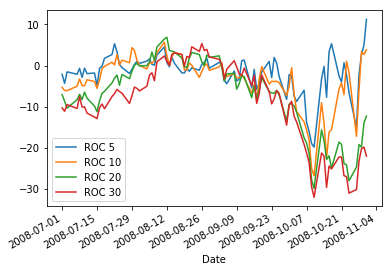

In [9]:
data['2008-07': '2008-10'][['ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

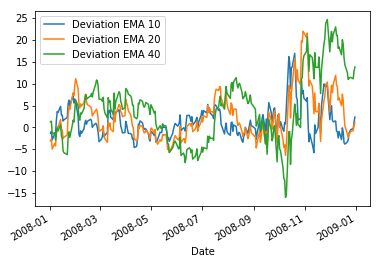

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

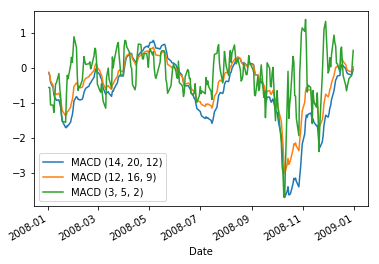

In [13]:
data['2008'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [14]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

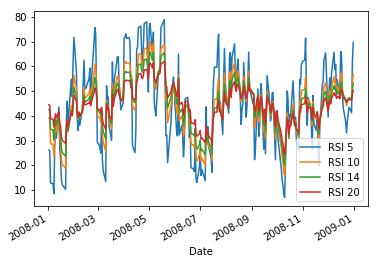

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

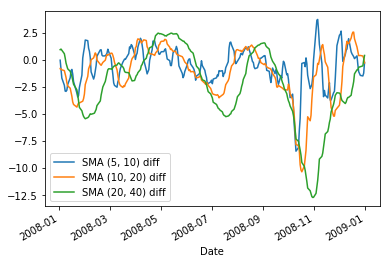

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX

In [20]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

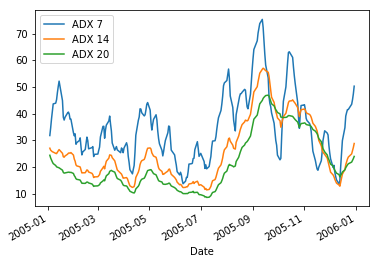

In [21]:
data['2005'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

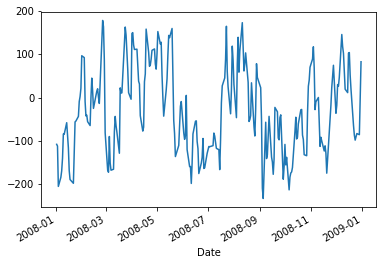

In [23]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

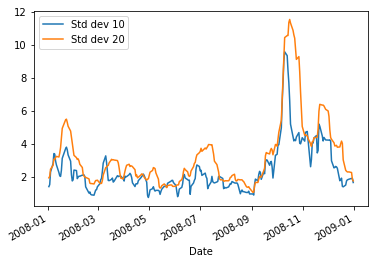

In [25]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [26]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD (12, 16, 9)","MACD (3, 5, 2)",...,"SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,CCI 14,Std dev 10,Std dev 20,Return,Extreme
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.415512,-0.046339,1.243877,6.835067,-1.793634,-2.853139,-0.432770,0.403900,0.239577,-0.059121,...,0.93594,2.150785,20.440722,20.489020,27.166137,-11.558144,1.199364,1.942356,0.069504,1.336039
1999-05-06,-0.267523,-1.595153,-0.637330,5.577426,-1.750246,-3.248888,-1.433450,0.351419,0.192688,-0.138730,...,0.76172,1.987895,19.525417,19.845702,28.433563,-22.992688,1.221660,1.940844,0.081651,1.642920
1999-05-07,1.313321,-0.598251,0.092678,4.247104,-0.453265,-2.032408,-0.610786,0.344498,0.190961,0.027138,...,0.67422,1.884770,18.655876,19.248335,29.519928,-3.573762,1.197413,1.942808,-1.226889,1.732266
1999-05-10,-1.001861,-1.658642,-1.455773,4.484667,-0.508662,-2.257764,-1.461731,0.309100,0.161892,-0.034079,...,0.54688,1.661723,17.785037,18.298311,28.103513,-26.438913,1.084316,1.888977,-2.384535,1.921237
1999-05-11,1.448598,-1.138434,0.184587,3.454888,0.980149,-0.836615,-0.315329,0.329205,0.186469,0.177762,...,0.37813,1.562503,17.270934,17.280123,24.967837,55.896787,0.789305,1.897725,-4.928604,2.008456


### Features

In [28]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [29]:
def to_class(y_vec, extreme):
    pos = y_vec > extreme
    neg = y_vec < -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [30]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, extreme_val) # df['Extreme']
    return X, y, ret

In [31]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret

In [32]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
    np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
    pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
    good_sum    =  8*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
    return bad_sum + np_sum + pn_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [34]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [50],
              'forest__max_depth': [4,None],
              'forest__max_features': [2,3,5],
              'forest__min_samples_split': [2,3,5],
              'forest__min_samples_leaf': [1,2,3],
#               'pca__n_components': [0.3, 0.7]
             }
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring=scorer,
                        cv=3)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 1999-05-05 00:00:00 to 1999-12-28 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    131
Pos         53
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      1.00      0.50         1
    Neutral       1.00      0.50      0.67         4

avg / total       0.87      0.60      0.63         5

---
Confusion matrix
 [[1 0]
 [2 2]]
0.0 [long] + 8.27003349155122 [short] = 8.27003349155122
From 1999-05-12 00:00:00 to 2000-01-04 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    130
Pos         55
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-05-19 00:00:00 to 2000-01-11 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    127
Pos         62
Neg         25
Name: Return, dtype: int64
---
Distribution:
Pos        2
Neutral    2
Neg        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.33      0.50      0.40         2
        Pos       0.00      0.00      0.00         2

avg / total       0.13      0.20      0.16         5

---
Confusion matrix
 [[0 0 1]
 [1 1 0]
 [0 2 0]]
-3.7092967409948496 [long] + 2.5519031141868487 [short] = -1.157393626808001

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
    Neutral       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 20.68078212815525 [short] = 20.68078212815525
From 1999-06-03 00:00:00 to 2000-01-26 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    133
Pos         53
Neg         28
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -1.0975153060345244 [short] = -1.0975153060345244
From 1999-06-10 00:00:00 to 2000-02-02 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    127
Pos         56
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [1 0 4]
 [0 0 0]]
0.6627770764986662 [long] + -0.9358288770053402 [short] = -0.273051800506674
From 1999-06-17 00:00:00 to 2000-02-09 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    115
Pos         53
Neg         46
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-06-24 00:00:00 to 2000-02-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    121
Pos         48
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-07-01 00:00:00 to 2000-02-24 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    133
Neg         41
Pos         40
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.33      0.50         3
        Pos       0.50      1.00      0.67         2

avg / total       0.80      0.60      0.57         5

---
Confusion matrix
 [[1 2]
 [0 2]]
10.325876512662058 [long] + 0.0 [short] = 10.325876512662058
From 1999-07-09 00:00:00 to 2000-03-02 00:00:00
Split result before upsampling: 165 -> 150 + 5

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-07-23 00:00:00 to 2000-03-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    125
Neg         45
Pos         44
Name: Return, dtype: int64
---
Distribution:
Pos        4
Neutral    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-07-30 00:00:00 to 2000-03-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    128
Pos         49
Neg         37
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.25      0.40         4
        Pos       0.25      1.00      0.40         1

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 3]
 [0 1]]
2.0649265882426104 [long] + 0.0 [short] = 2.0649265882426104
From 1999-08-06 00:00:00 to 2000-03-30 00:00:00
Split result before upsampling: 165 -> 150 + 5

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-08-13 00:00:00 to 2000-04-06 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    110
Pos         75
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-08-20 00:00:00 to 2000-04-13 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    113
Pos         72
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-08-27 00:00:00 to 2000-04-20 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    118
Pos         66
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         4
        Pos       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[4 0]
 [0 1]]
8.134191176470583 [long] + 0.0 [short] = 8.134191176470583
From 1999-09-03 00:00:00 to 2000-04-28 00:00:00
Split result before upsampling: 165 -> 150 + 5
-

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 0 0]
 [1 3 0]
 [0 1 0]]
0.0 [long] + 1.2112537186570238 [short] = 1.2112537186570238
From 1999-09-20 00:00:00 to 2000-05-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    120
Pos         58
Neg         36
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       1.00      0.75      0.86         4
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.60      0.69         5

---
Confusion matrix
 [[0 0 1]
 [0 3 1]
 [0 0 0]]
-1.8313415249957998 [long] + 0.0 [short] = -1.8313415249957998
From 1999-09-27 00:00:00 to 2000-05-19 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    118
Pos         51
Neg         45
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         3
        Pos       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
2.9199921322583977 [long] + 0.0 [short] = 2.9199921322583977
From 1999-10-04 00:00:00 to 2000-05-26 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    124
Pos         49
Neg         41
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
27.522103381418543 [long] + 0.0 [short] = 27.522103381418543
From 1999-10-11 00:00:00 to 2000-06-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    128
Pos         46


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         3
        Pos       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
9.122239588335159 [long] + 0.0 [short] = 9.122239588335159
From 1999-10-18 00:00:00 to 2000-06-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    125
Pos         51
Neg         38
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-1.1179064283371898 [long] + 0.0 [short] = -1.1179064283371898
From 1999-10-25 00:00:00 to 2000-06-19 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    117
Pos         66
Neg         31
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-5.873201030236341 [long] + 0.0 [short] = -5.873201030236341
From 1999-11-01 00:00:00 to 2000-06-26 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    119
Pos         67
Neg         28
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
0.0 [long] + 3.676145764475691 [short] = 3.676145764475691
From 1999-11-08 00:00:00 to 2000-07-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    131
Pos         56
Neg         27
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.50      0.67      0.57         3
        Pos       0.00      0.00      0.00         2

avg / total       0.30      0.40      0.34         5

---
Confusion matrix
 [[0 0 0]
 [1 2 0]
 [0 2 0]]
0.0 [long] + -1.6868412261714205 [short] = -1.6868412261714205
From 1999-11-15 00:00:00 to 2000-07-11 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    141
Pos         48
Neg         25
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.50      0.67         4
        Pos       0.00      0.00      0.00         1

avg / total       0.80      0.40      0.53         5

---
Confusion matrix
 [[0 0 0]
 [2 2 0]
 [1 0 0]]
0.0 [long] + -2.3940926338605117 [short] = -2.3940926338605117
From 1999-11-22 00:00:00 to 2000-07-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    148
Pos         42
Neg         24
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-11-30 00:00:00 to 2000-07-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    140
Pos         50
Neg         24
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 1999-12-07 00:00:00 to 2000-08-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    137
Pos         54
Neg         23
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       0.33      0.50      0.40         2
        Pos       0.50      0.33      0.40         3

avg / total       0.43      0.40      0.40         5

---
Confusion matrix
 [[1 1]
 [2 1]]
4.663029373922067 [long] + 0.0 [short] = 4.663029373922067
From 1999-12-14 00:00:00 to 2000-08-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
-

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.50      1.00      0.67         1

avg / total       0.10      0.20      0.13         5

---
Confusion matrix
 [[0 0 0]
 [3 0 1]
 [0 0 1]]
5.943238059877576 [long] + -4.917260291241621 [short] = 1.025977768635955
From 1999-12-21 00:00:00 to 2000-08-15 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    138
Neg         39
Pos         37
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.75      0.86         4
        Pos       0.00      0.00      0.00         1

avg / total       0.80      0.60      0.69         5

---
Confusion matrix
 [[0 0 0]
 [1 3 0]
 [1 0 0]]
0.0 [long] + -5.441292623473393 [short] = -5.441292623473393
From 1999-12-29 00:00:00 to 2000-08-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    133
Pos         46
Neg         35
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
0.0 [long] + -0.0614990519676617 [short] = -0.0614990519676617
From 2000-01-05 00:00:00 to 2000-08-29 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    131
Pos         49
Neg         34
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 6.152672652312885 [short] = 6.152672652312885
From 2000-01-12 00:00:00 to 2000-09-06 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    137
Pos         48
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neg        4
Neutral    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         4
    Neutral       0.33      1.00      0.50         1

avg / total       0.87      0.60      0.63         5

---
Confusion matrix
 [[2 2]
 [0 1]]
0.0 [long] + 9.307546520095311 [short] = 9.307546520095311
From 2000-01-20 00:00:00 to 2000-09-13 00:00:00
Split result before 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 4 1]
 [0 0 0]
 [0 0 0]]
-3.8514184239972105 [long] + 0.0 [short] = -3.8514184239972105
From 2000-01-27 00:00:00 to 2000-09-20 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    150
Pos         39
Neg         25
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 1 0]
 [0 0 4]
 [0 0 0]]
-5.395070898247278 [long] + 0.0 [short] = -5.395070898247278
From 2000-02-03 00:00:00 to 2000-09-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    136
Neg         40
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.50      0.33      0.40         3
        Pos       0.00      0.00      0.00         0

avg / total       0.30      0.20      0.24         5

---
Confusion matrix
 [[0 1 1]
 [0 1 2]
 [0 0 0]]
-5.208575023242679 [long] + 0.0 [short] = -5.208575023242679
From 2000-02-10 00:00:00 to 2000-10-04 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    124
Neg         52
Pos         38
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-28.349571257259477 [long] + 0.0 [short] = -28.349571257259477
From 2000-02-17 00:00:00 to 2000-10-11 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    127
Neg         50
Pos         37
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 1]
 [0 0 4]
 [0 0 0]]
-2.597037075398989 [long] + 0.0 [short] = -2.597037075398989
From 2000-02-25 00:00:00 to 2000-10-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    130
Neg         52
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.33      0.50         3
        Pos       0.00      0.00      0.00         2

avg / total       0.60      0.20      0.30         5

---
Confusion matrix
 [[0 0 0]
 [1 1 1]
 [2 0 0]]
2.6760563380281654 [long] + -13.458976199289307 [short] = -10.782919861261142
From 2000-03-03 00:00:00 to 2000-10-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    118
Neg         67
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [1 0 0]]
0.0 [long] + -12.896673316154917 [short] = -12.896673316154917
From 2000-03-10 00:00:00 to 2000-11-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    126
Neg         64
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-03-17 00:00:00 to 2000-11-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    127
Neg         59
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-03-24 00:00:00 to 2000-11-15 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    130
Neg         53
Pos         31
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 3 0]
 [0 0 2]
 [0 0 0]]
-1.8177461755241042 [long] + 0.0 [short] = -1.8177461755241042
From 2000-03-31 00:00:00 to 2000-11-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    138
Neg         47
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       1.00      0.50      0.67         4
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.40      0.53         5

---
Confusion matrix
 [[0 0 1]
 [0 2 2]
 [0 0 0]]
-3.915731722284721 [long] + 0.0 [short] = -3.915731722284721
From 2000-04-07 00:00:00 to 2000-11-30 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    127
Neg         59
Pos         28
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.75      0.75      0.75         4
        Pos       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

---
Confusion matrix
 [[0 0 0]
 [1 3 0]
 [0 1 0]]
0.0 [long] + -2.025742388758789 [short] = -2.025742388758789
From 2000-04-14 00:00:00 to 2000-12-07 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    120
Neg         68
Pos         26
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.67      0.80         3
    Neutral       0.50      0.50      0.50         2
        Pos       0.00      0.00      0.00         0

avg / total       0.80      0.60      0.68         5

---
Confusion matrix
 [[2 1 0]
 [0 1 1]
 [0 0 0]]
-0.945403335534234 [long] + 11.723861186534934 [short] = 10.7784578510007
From 2000-04-24 00:00:00 to 2000-12-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    128
Neg         62
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         2
    Neutral       0.75      1.00      0.86         3

avg / total       0.85      0.80      0.78         5

---
Confusion matrix
 [[1 1]
 [0 3]]
0.0 [long] + 3.4185749308851987 [short] = 3.41

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
0.0 [long] + 0.819841821737155 [short] = 0.819841821737155
From 2000-05-15 00:00:00 to 2001-01-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    128
Neg         62
Pos         24
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       1.00      0.33      0.50         3

avg / total       0.60      0.20      0.30         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [0 2 1]]
3.6026006792819087 [long] + -0.18896391410685442 [short] = 3.4136367651750543
From 2000-05-22 00:00:00 to 2001-01-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    135
Neg         58
Pos         21
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [1 2 0]]
0.0 [long] + -9.182312041334818 [short] = -9.182312041334818
From 2000-05-30 00:00:00 to 2001-01-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    146
Neg         53
Pos         15
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-06 00:00:00 to 2001-01-30 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Dist

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-13 00:00:00 to 2001-02-06 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    136
Neg         42
Pos         36
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-20 00:00:00 to 2001-02-13 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    140
Neg         42
Pos         32
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-06-27 00:00:00 to 2001-02-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    140
Neg         45
Pos         29
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.67      1.00      0.80         2
        Pos       0.00      0.00      0.00         0

avg / total       0.27      0.40      0.32         5

---
Confusion matrix
 [[0 1 2]
 [0 2 0]
 [0 0 0]]
-12.946082591372488 [long] + 0.0 [short] = -12.946082591372488
From 2000-07-05 00:00:00 to 2001-02-28 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    129
Neg         61
Pos         24
Name: Return, dtype: int64
---
Distribution:
Neg        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-07-12 00:00:00 to 2001-03-07 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    114
Neg         79
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
    Neutral       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-07-19 00:00:00 to 2001-03-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    110
Neg         83
Pos         21
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Neg        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-07-26 00:00:00 to 2001-03-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    108
Neg         86
Pos         20
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Neg        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-08-02 00:00:00 to 2001-03-28 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    101
Neg         99
Pos         14
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 2]
 [0 1 0]]
-2.593364397485265 [long] + -0.43830651314185065 [short] = -3.0316709106271156
From 2000-08-09 00:00:00 to 2001-04-04 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    105
Neg         98
Pos         11
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [1 2 0]]
0.0 [long] + -8.128921391690746 [short] = -8.128921391690746
From 2000-08-16 00:00:00 to 2001-04-11 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    108
Neg         96
Pos         10
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-08-23 00:00:00 to 2001-04-19 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    114
Neg         86
Pos         14
Name: Return, dtype: int64
---
Distribution:
Pos        3
Neutral    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         2
        Pos       0.00      0.00      0.00         3

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [2 0 0]
 [2 1 0]]
0.0 [long] + -16.160043118738443 [short] = -16.160043118738443
From 2000-08-30 00:00:00 to 2001-04-26 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    114
Neg         75
Pos         25
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.75      1.00      0.86         3
        Pos       0.00      0.00      0.00         2

avg / total       0.45      0.60      0.51         5

---
Confusion matrix
 [[0 0 0]
 [0 3 0]
 [1 1 0]]
0.0 [long] + -3.7835170258266215 [short] = -3.7835170258266215
From 2000-09-07 00:00:00 to 2001-05-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    103
Neg         66
Pos         45
Name: Return, dtype: int64
---
Distribution:
Neutral    4
Pos        1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         4
        Pos       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [4 0 0]
 [1 0 0]]
0.0 [long] + -2.4884074770479936 [short] = -2.4884074770479936
From 2000-09-14 00:00:00 to 2001-05-10 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    103
Neg         59
Pos         52
Name: Return, dtype: int64
---
Distribution:
Neutral    3
Pos        2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0 0]
 [3 0 0]
 [2 0 0]]
0.0 [long] + -16.100280880320295 [short] = -16.100280880320295
From 2000-09-21 00:00:00 to 2001-05-17 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    106
Pos         55
Neg         53
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + 1.0431572036606163 [short] = 1.0431572036606163
From 2000-09-28 00:00:00 to 2001-05-24 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    115
Pos         52
Neg         47
Name: Return, dtype: int64
---
Distribution:
Neutral    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

    Neutral       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 0.0 [short] = 0.0
From 2000-10-05 00:00:00 to 2001-06-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neutral    119
Pos         53
Neg         42
Name: Retur

KeyboardInterrupt: 

In [38]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [39]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [40]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2000-05-26,NaN,2,1,5,50,27.522103,1.0
2000-01-19,NaN,5,3,3,50,20.680782,0.8
2000-04-28,NaN,3,2,3,50,13.557920,1.0
2000-12-07,NaN,2,2,2,50,10.778458,0.6
2000-02-24,NaN,3,1,2,50,10.325877,0.6
2000-09-06,4.0,3,3,3,50,9.307547,0.6
2000-06-05,4.0,3,3,3,50,9.122240,0.4
2001-06-01,4.0,5,3,2,50,8.330201,0.6
1999-12-28,NaN,5,1,5,50,8.270033,0.6
2000-04-20,NaN,3,2,5,50,8.134191,1.0


In [41]:
params.describe()

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,24.0,73.000000,73.000000,73.000000,73.0,73.000000,73.000000
mean,4.0,3.191781,1.780822,3.150685,50.0,-0.110403,0.394521
std,0.0,1.162583,0.837433,1.150739,0.0,7.673012,0.344759
min,4.0,2.000000,1.000000,2.000000,50.0,-28.349571,0.000000
25%,4.0,2.000000,1.000000,2.000000,50.0,-2.394093,0.000000
50%,4.0,3.000000,2.000000,3.000000,50.0,0.000000,0.400000
75%,4.0,5.000000,3.000000,3.000000,50.0,1.211254,0.600000
max,4.0,5.000000,3.000000,5.000000,50.0,27.522103,1.000000


In [42]:
params['Sum of return'].sum()

-8.0594220108148065

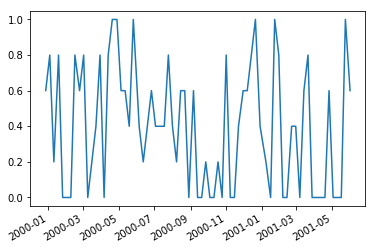

In [43]:
params['Accuracy'].plot()

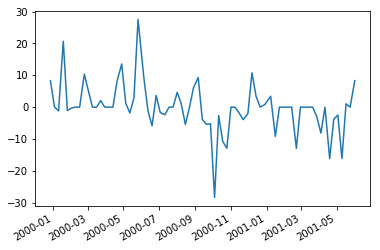

In [44]:
params['Sum of return'].plot()

### Feature importances

In [45]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [46]:
features.idxmax(axis=1).value_counts()

ADX 20               16
SMA (20, 40) diff    16
Deviation EMA 40      8
Std dev 10            7
Std dev 20            7
RSI 20                4
ROC 20                3
MACD (12, 16, 9)      2
SMA (10, 20) diff     2
ADX 14                2
RSI 10                1
MACD (3, 5, 2)        1
RSI 5                 1
ADX 7                 1
MACD (14, 20, 12)     1
SMA (5, 10) diff      1
dtype: int64

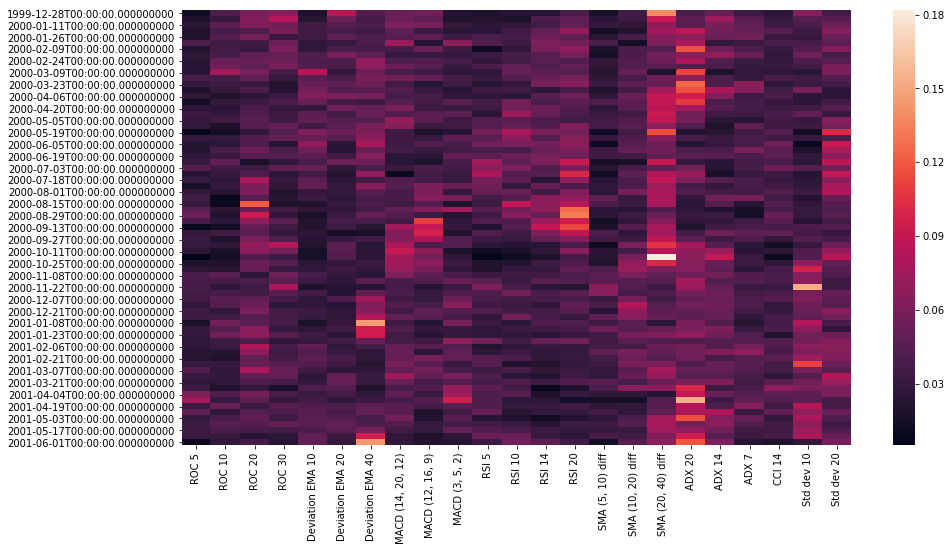

In [47]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


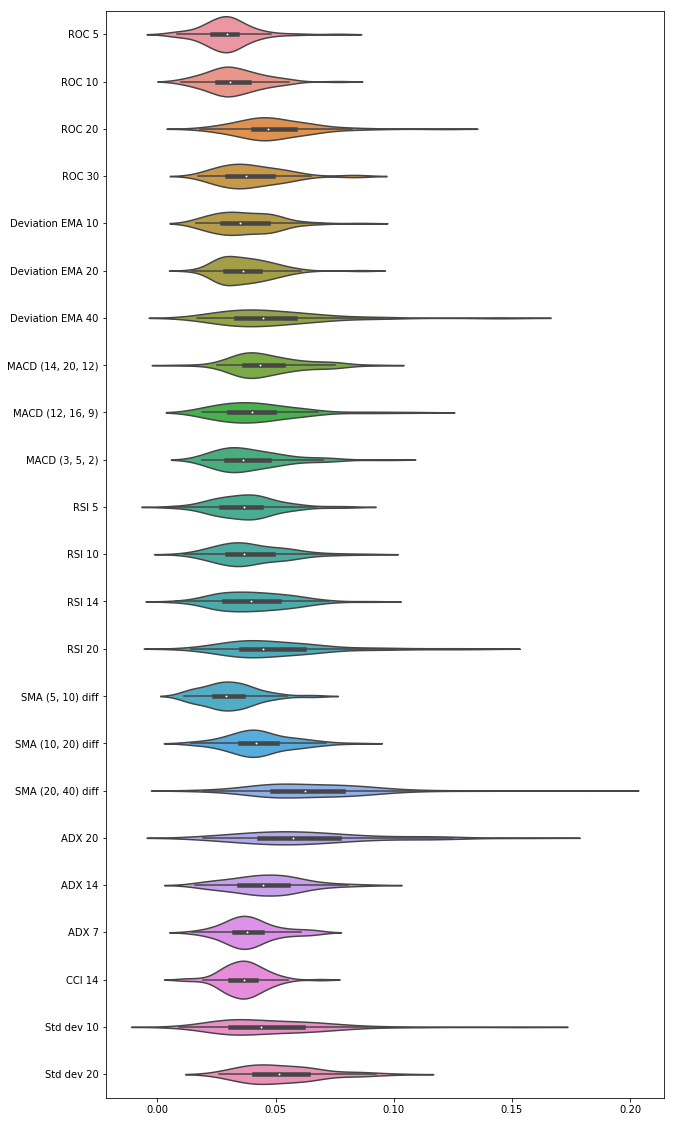

In [48]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')